In [1]:
import csv
import sys
import copy

import numpy as np
import json
import random
import itertools

import pprint
pp = pprint.PrettyPrinter(indent=2)

import nltk

import pandas as pd
import matplotlib.pylab as plt
from matplotlib.colors import LinearSegmentedColormap

import seaborn as sns

# Response Data Analysis

In [2]:
teacher_joined_survey = pd.read_csv("data/response_exp_anonymized.csv")

In [3]:
teacher_joined_survey['game'] = teacher_joined_survey.game.apply(lambda x: json.loads(x))

In [4]:
final_level = teacher_joined_survey[teacher_joined_survey.level_number == 10]
final_level.groupby(["comm_viz", "concept_number"]).learner_concept.mean()

comm_viz      concept_number
chat|full     2                 0.716667
chat|partial  2                 0.345588
Name: learner_concept, dtype: float64

## Plot new configuration


In [5]:
def get_viz_string(object_dict, class_features):
    
    pos_features = set(class_features[1])
    neg_features = set(class_features[-1])
    
    return class_features[object_dict["value"]][object_dict["mask_value"]]

def update_object_with_mask(object_dict, class_features):
    
    string = get_viz_string(object_dict, class_features)
    
    color = 'm' if string[0] == '1' else 'c'
    shape = '^' if string[1] == '1' else 's'
    hollow = True if string[2] == '1' else False
    
    object_dict.update({"color": color, "shape": shape, "hollow": hollow})
    
    return object_dict


def plot_boolean_colors(original_object_list, class_features,
                        plot_x=5, plot_y=5, title="", label_values=False, ax=None):    

    if ax is None:
        ax = plt.figure(figsize=(plot_x, plot_y)).gca()
    
    object_list = copy.deepcopy(original_object_list)
    object_list = [update_object_with_mask(o, class_features) for o in object_list]
    objects_df = pd.DataFrame(object_list)
    
    ax.set_facecolor('w')
        
    for s, df in objects_df[objects_df.hollow == False].groupby("shape"):
        ax.scatter(df.x, df.y, s=400, 
                    marker=s,
                    color=df.color.values)
    
    for s, df in objects_df[objects_df.hollow == True].groupby("shape"):
        ax.scatter(df.x, df.y, s=400, marker=s,
                   edgecolors=df.color.values,
                   facecolors='none',
                  linewidths=4)
                
    ax.set_xlim(0, 75)
    ax.set_ylim(75,0)
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_title(title)
    ax.axis("off")

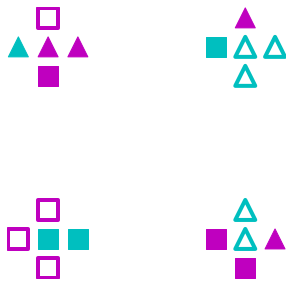

In [6]:
level_to_plot = 2

CLASS_TWO_FEATURES = {
    1: [ "011", "100", "001", "110"],
    -1:["000",  "111", "010",  "101"]}

ALL_FEATURES = set(''.join(s) for s in itertools.product('01', repeat=3))

to_plot = teacher_joined_survey[teacher_joined_survey.level_number == 2]

plot_boolean_colors(to_plot.game.iloc[0]["config"]['frame_data']['objects'], class_features=CLASS_TWO_FEATURES)

## Linguistic Teaching

In [7]:
teacher_joined_survey.chat_text = teacher_joined_survey.chat_text.apply(str)

for k, games in teacher_joined_survey.groupby("task_uuid"):

    continue
    games = games.sort_values(by='level_number')
    print("\n{} visibility, {} complexity\nCumulative Score: {}".format(games.iloc[0]["visibility"], games.iloc[0]["concept_number"], games.iloc[-1]["cum_player_score"]))
    print("{}".format(k))
    for gid, g in games.iterrows():
        print("{} & ``{}''\\\\".format(g.player_score, g.chat_text.replace("|", " ")))


# Demonstration-Optimality Analysis

In [8]:
demos_to_analyze = pd.read_csv("data/exp2_demonstrations.csv")
demos_to_analyze['game'] = demos_to_analyze.game.apply(lambda x: json.loads(x))

In [9]:
def collected_positive_objects(game):
    
    object_list = [e["data"]["object"] for e in game["game_events"]]
    if not object_list:
        return 0
    
    df = pd.DataFrame.from_records(object_list)
    negative_objects = df[df["value"] != 1]

    # If we collected *any* negative objects, return -1
    if len(negative_objects) > 0:
        return -1

    # If we didn't collect any negatives, return the number of collected objects
    return len(df)

def variety_positive_objects(game):
    
    object_list = [e["data"]["object"] for e in game["game_events"]]
    if not object_list:
        return 0
    
    df = pd.DataFrame.from_records(object_list)
    negative_objects = df[df["value"] != 1]

    # If we collected *any* negative objects, return -1
    if len(negative_objects) > 0:
        return -1
    
    return df.mask_value.nunique()

In [10]:
def max_possible_features(game):
    
    object_list = game["config"]["frame_data"]["objects"]
    
    df = pd.DataFrame.from_records(object_list)
    positive_objects = df[df["value"] == 1]
    n_features = positive_objects.groupby("cluster_id").mask_value.nunique().max()
    return n_features

def max_possible_score(game):
    
    object_list = game["config"]["frame_data"]["objects"]
    
    df = pd.DataFrame.from_records(object_list)
    positive_objects = df[df["value"] == 1]
    max_score = positive_objects.groupby("cluster_id").size().max()
    return max_score

In [11]:
demos_to_analyze["max_score"] = demos_to_analyze.game.apply(lambda x: max_possible_score(x))
demos_to_analyze["max_features"] = demos_to_analyze.game.apply(lambda x: max_possible_features(x))

demos_to_analyze["teacher_score"] = demos_to_analyze.game.apply(lambda x: collected_positive_objects(x))
demos_to_analyze["teacher_features"] = demos_to_analyze.game.apply(lambda x: variety_positive_objects(x))

In [12]:
demos_to_analyze["optimal_features"] = demos_to_analyze.teacher_features >= demos_to_analyze.max_features
demos_to_analyze["optimal_score"] = demos_to_analyze.teacher_score >= demos_to_analyze.max_score
demos_to_analyze["optimal_both"] = demos_to_analyze.optimal_features & demos_to_analyze.optimal_score

In [13]:
score_maximizing_not_feature_maximizing = demos_to_analyze[(demos_to_analyze.optimal_score & ~demos_to_analyze.optimal_features)]
feature_maximizing_not_score_maximizing = demos_to_analyze[(~demos_to_analyze.optimal_score & demos_to_analyze.optimal_features)]

In [14]:
total = len(demos_to_analyze)
print(f'Total demonstration trajectories: {total}')

n_score_maximizing = len(demos_to_analyze[demos_to_analyze.optimal_score])
print(f'\nScore-maximizing: {n_score_maximizing}')

n_feature_maximizing = len(demos_to_analyze[demos_to_analyze.optimal_features])
print(f'Feature-maximizing: {n_feature_maximizing}')

print(f'\nScore but _not_ feature-maximizing: {len(score_maximizing_not_feature_maximizing)}')
print(f'Feature but _not_ score-maximizing: {len(feature_maximizing_not_score_maximizing)}')

print(f'\n{int(100*n_score_maximizing/total)}% maximize score.\n{int(100*n_feature_maximizing/total)}% maximize features.')

Total demonstration trajectories: 1430

Score-maximizing: 1078
Feature-maximizing: 1200

Score but _not_ feature-maximizing: 0
Feature but _not_ score-maximizing: 122

75% maximize score.
83% maximize features.


In [15]:
pct_optimal = (demos_to_analyze.groupby('task_uuid')[['optimal_score', 'optimal_features']].sum() / 10)

all_experiment_two_data = pd.read_csv("data/exp2_anonymized.csv")

joined_with_demo_data = all_experiment_two_data.set_index('teacher_uuid').join(pct_optimal).reset_index().rename({"index": "teacher_uuid"}, axis=1)

In [16]:
demo_only = joined_with_demo_data[joined_with_demo_data.communication == 'demo']

demo_only.difficulty_teacher = 6 - demo_only.difficulty_teacher

/var/folders/gv/42lb0z1j4dxf3wsk74nrxwx80000gn/T/ipykernel_60365/1045691239.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_only.difficulty_teacher = 6 - demo_only.difficulty_teacher


In [17]:
demo_only[["teacher_uuid", 'optimal_score', 'optimal_features', 'difficulty_teacher']].to_csv('data/demonstration_optimality_and_difficulty.csv')

In [18]:
demo_by_teacher = demos_to_analyze.groupby(["task_uuid", 'visibility', 'boolean_complexity'])['optimal_features', 'optimal_score'].sum()
demo_by_teacher.to_csv('data/demonstration_optimality_by_condition.csv')

/var/folders/gv/42lb0z1j4dxf3wsk74nrxwx80000gn/T/ipykernel_60365/3282461710.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  demo_by_teacher = demos_to_analyze.groupby(["task_uuid", 'visibility', 'boolean_complexity'])['optimal_features', 'optimal_score'].sum()
